<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси.

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, для чего требуется построить модель для такого предсказания.

Этапы:

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке и выводы.

## Подготовка

In [1]:
! pip install -U scikit-learn -q
! pip install phik -q

In [2]:
# импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загружаем функцию для работы с метриками
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
# загрузка данных
taxi_orders = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# общая информация о данных
taxi_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi_orders.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# проверим, в хронологическом ли порядке расположены даты и время:
taxi_orders.index.is_monotonic

True

In [7]:
taxi_orders.index.min()

Timestamp('2018-03-01 00:00:00')

In [8]:
taxi_orders.index.max()

Timestamp('2018-08-31 23:50:00')

Файл содержит сведения о количестве заказов в 26 496 временных интервалах длительностью 10 минут в период с 2018-03-01 по 2018-08-31 включительно, расположенных в хронологическом порядке. Пропуски в данных отсутствуют.

Для последующего прогноза количества заказов такси на следующий час, изменим интервал временного ряда с 10 мин. на 1 час: 

In [9]:
taxi_orders = taxi_orders.resample('1H').sum()
taxi_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В результате ресемплирования получили сведения о суммарном количестве заказов по часам за 4 416 часов в периоде с 2018-03-01 по 2018-08-31 включительно.

## Анализ

Добавим в таблицу скользящее среднее и стандартное отклонение за 24 часа:

In [10]:
taxi_orders['rolling_mean'] = taxi_orders.shift().rolling(24).mean()
taxi_orders['rolling_std'] = taxi_orders['num_orders'].shift().rolling(24).std()
taxi_orders = taxi_orders.dropna()

Посмотрим на динамику заказов на графике за весь период:

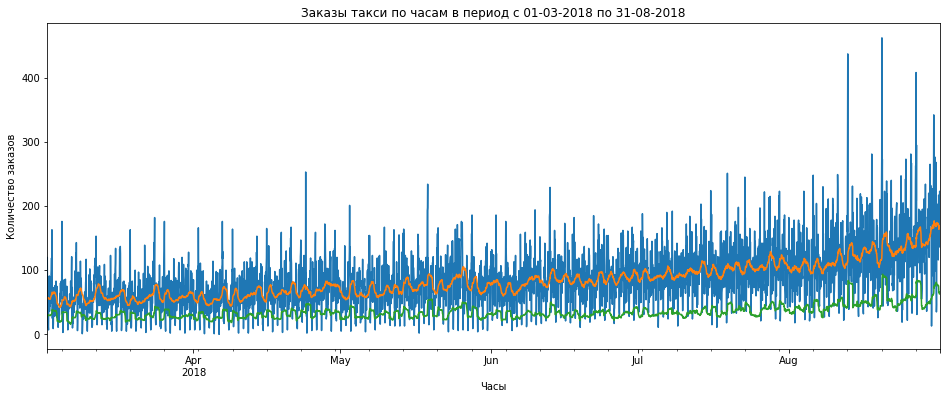

In [11]:
taxi_orders.plot(figsize = (16,6), legend = None)
plt.title ('Заказы такси по часам в период с 01-03-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.ylabel ('Количество заказов')
plt.show();

Посмотрим на динамику заказов на графике за август 2018:

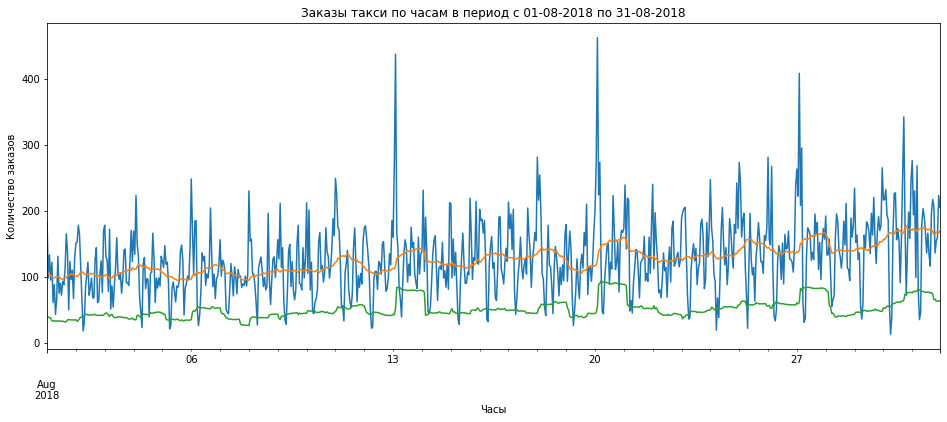

In [12]:
taxi_orders['2018-08-01':'2018-08-31'].plot(figsize = (16,6), legend = None)
plt.title ('Заказы такси по часам в период с 01-08-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.ylabel ('Количество заказов')
plt.show();

Разложим временной ряд на три составляющие: тренд, сезонность и остаток. 

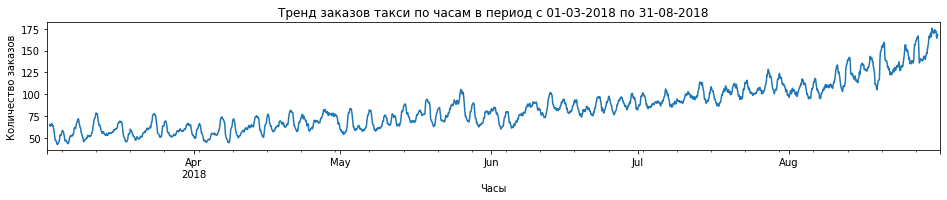

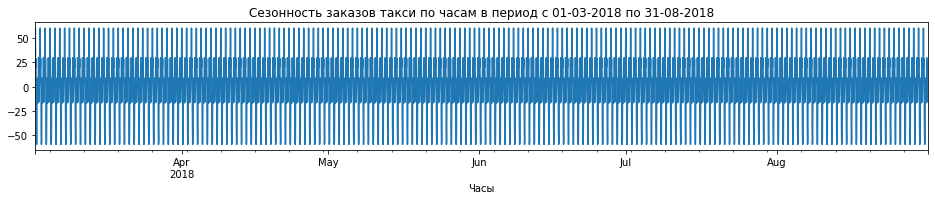

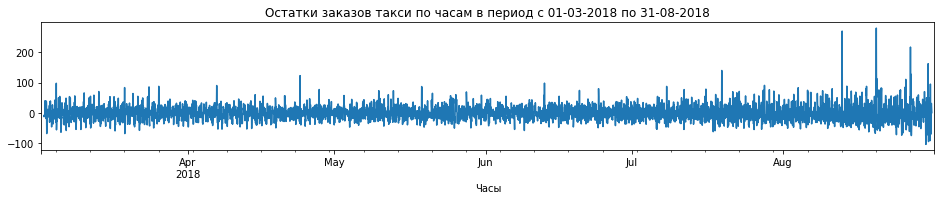

<Figure size 432x288 with 0 Axes>

In [13]:
decomposed = seasonal_decompose(taxi_orders['num_orders']) 
plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title ('Тренд заказов такси по часам в период с 01-03-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.ylabel ('Количество заказов')
plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность заказов такси по часам в период с 01-03-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки заказов такси по часам в период с 01-03-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.show()
plt.tight_layout()

Построим графики за август 2018 года.

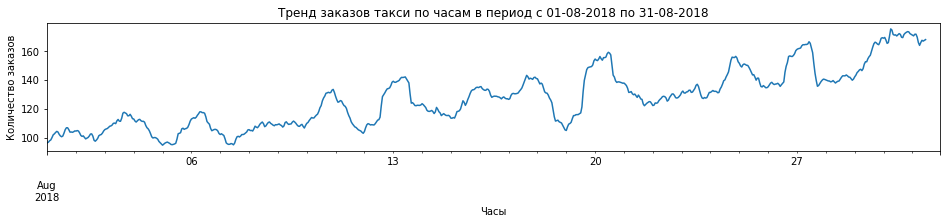

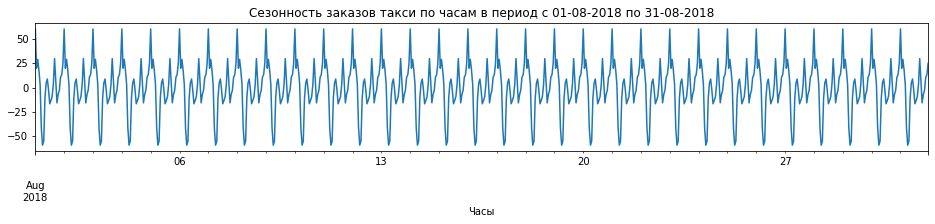

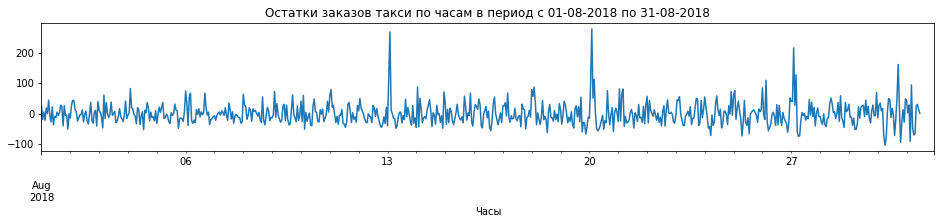

<Figure size 432x288 with 0 Axes>

In [14]:
decomposed = seasonal_decompose(taxi_orders['num_orders']) 
plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title ('Тренд заказов такси по часам в период с 01-08-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.ylabel ('Количество заказов')
plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность заказов такси по часам в период с 01-08-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.show()
plt.figure(figsize=(16, 8))
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Остатки заказов такси по часам в период с 01-08-2018 по 31-08-2018')
plt.xlabel ('Часы')
plt.show()
plt.tight_layout()

Для проверки временного ряда на стационарность используем тест Дики-Фуллера:
- Ho (нулевая гипотеза): данные временных рядов нестационарны
- H1 (альтернативная гипотеза): данные временных рядов являются стационарными

In [15]:
values = taxi_orders['num_orders'].values
res = adfuller(values)
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
 
# критические значения на разных альфа-уровнях:
print('Критические значения на разных альфа-уровнях:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -3.025706
p-value: 0.032563
Критические значения на разных альфа-уровнях:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Статистика ADF ненамного отличается от критических значений на разных уровнях, а также значение p ненамного больше 0,05, что означает, что мы можем отклонить нулевую гипотезу с достоверностью 95%, что означает, что данные временных рядов умеренно стационарны.

Добавим признаков:

In [16]:
#календарныe признаки: день недели и час:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # предыдущие значения признака кол-ва заказов и скользящее среднее (без текущего значения):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean_lag'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
# задаем признаки функции: датасет, количество отстающих признаков и размер окна для расчета скользящего среднего:    
make_features(taxi_orders, 4, 4)

In [17]:
#удалим строки с пустыми значениями
taxi_orders = taxi_orders.dropna()
taxi_orders.head()

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean_lag
datetime,,,,,,,,,,
2018-03-02 04:00:00,20,56.958333,29.322019,4,4,64.0,75.0,120.0,90.0,87.25
2018-03-02 05:00:00,11,56.000000,30.161882,4,5,20.0,64.0,75.0,120.0,69.75
2018-03-02 06:00:00,11,56.208333,29.816802,4,6,11.0,20.0,64.0,75.0,42.50
2018-03-02 07:00:00,7,56.166667,29.881893,4,7,11.0,11.0,20.0,64.0,26.50
2018-03-02 08:00:00,46,55.833333,30.401182,4,8,7.0,11.0,11.0,20.0,12.25


Проверим признаки на мультиколлинеарность.

interval columns not set, guessing: ['num_orders', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_lag']


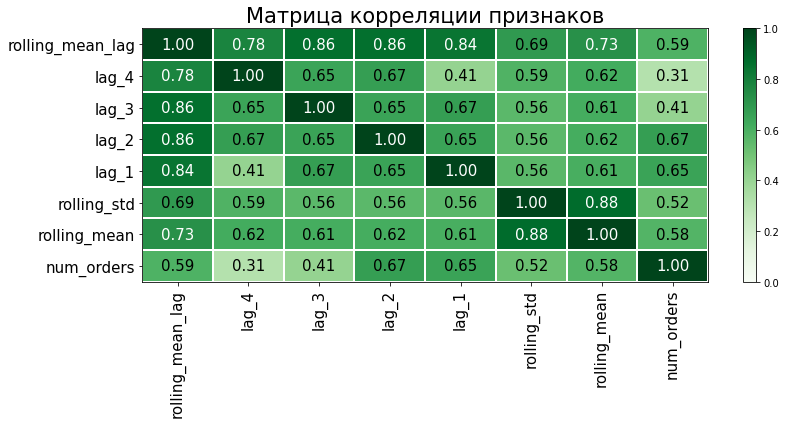

In [18]:
num_col = ['num_orders', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_lag']
phik_overview = phik_matrix(taxi_orders[num_col])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков',
    fontsize_factor=1.5,
    figsize=(12, 6)
) 

Мультиколлинеарности между входными числовыми признаками не наблюдается. Согласно матрице коррреляции на целевой признак `num_orders` заметное влияние оказывают значения предыдущего и предпредыдущего период (`lag_1` и `lag_2`), скользящее среднее (`rolling_mean` и `rolling_mean_lag`) и скользящее стандартное отклонение (`rolling_std`).

## Обучение

Разделим полученный датасет на обучающую и тестовую выборки в соотношении 9:1, выделим целевой (y) и входные признаки (X). 

In [19]:
X = taxi_orders.drop('num_orders', axis=1)
y = taxi_orders ['num_orders']
X_train, X_test, y_train, y_test = train_test_split (X, y, shuffle=False, test_size=0.1)
#проверим на хроонологию
print('Диапазон тренировочной выборки: от', X_train.index.min(), 'до', X_train.index.max())
print('Диапазон тестовой выборки: от', X_test.index.min(), 'до', X_test.index.max())
print()
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Диапазон тренировочной выборки: от 2018-03-02 04:00:00 до 2018-08-13 16:00:00
Диапазон тестовой выборки: от 2018-08-13 17:00:00 до 2018-08-31 23:00:00

Размер тренировочной выборки: (3949, 9)
Размер тестовой выборки: (439, 9)


Обучим разные модели с различными гиперпараметрами. 

In [20]:
ohe_col = ['dayofweek', 'hour']
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first'), ohe_col)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Lasso())
])

param_grid = [
    # словарь для модели Lasso()
    {
        'models': [Lasso()],
        'models__alpha': [0.1, 1.0, 10.0, 100.0]
    },
     # словарь для модели Ridge()
    {
        'models': [Ridge()],
        'models__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor()],
        'models__max_depth': range(5, 15),
        'models__max_features': range(1, 15)   
    },
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(loss_function="RMSE", iterations=40)],
        'models__iterations': range(40, 100)
    }
]

In [21]:
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=pipe_final, cv=tscv,
                      scoring = 'neg_root_mean_squared_error',
                      param_grid=param_grid)
gsearch.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gsearch.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(gsearch.best_score_))

Learning rate set to 0.5
0:	learn: 26.2064587	total: 49ms	remaining: 1.91s
1:	learn: 23.8968895	total: 50.9ms	remaining: 966ms
2:	learn: 22.4034073	total: 52.5ms	remaining: 648ms
3:	learn: 21.6545200	total: 54.1ms	remaining: 487ms
4:	learn: 20.8489286	total: 55.7ms	remaining: 390ms
5:	learn: 20.1665959	total: 57.3ms	remaining: 325ms
6:	learn: 19.7621206	total: 58.9ms	remaining: 278ms
7:	learn: 19.3225347	total: 60.5ms	remaining: 242ms
8:	learn: 19.0519781	total: 62.3ms	remaining: 215ms
9:	learn: 18.7354689	total: 63.9ms	remaining: 192ms
10:	learn: 18.3753377	total: 65.5ms	remaining: 173ms
11:	learn: 17.8652960	total: 67.1ms	remaining: 157ms
12:	learn: 17.7367697	total: 68.7ms	remaining: 143ms
13:	learn: 17.5284539	total: 70.2ms	remaining: 130ms
14:	learn: 17.3409075	total: 71.9ms	remaining: 120ms
15:	learn: 17.0423225	total: 73.6ms	remaining: 110ms
16:	learn: 16.7324312	total: 75.1ms	remaining: 102ms
17:	learn: 16.3453879	total: 76.8ms	remaining: 93.8ms
18:	learn: 16.0431889	total: 78.

Лучшим образом себя показала модель линейной регресии с L2-регуляризацией при силе регуляризации = 0.1 (метрика RMSE на тренировочной выборке = 26.65).

In [22]:
gsearch.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe', OneHotEncoder(drop='first'),
                                    ['dayofweek', 'hour'])])),
  ('models', Ridge(alpha=0.1))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(drop='first'),
                                  ['dayofweek', 'hour'])]),
 'models': Ridge(alpha=0.1),
 'preprocessor__force_int_remainder_cols': True,
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'passthrough',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor__transformers': [('ohe',
   OneHotEncoder(drop='first'),
   ['dayofweek', 'hour'])],
 'preprocessor__verbose': False,
 'preprocessor__verbose_feature_names_out': True,
 'preprocessor__ohe': OneHotEncoder(drop='first'),
 'preprocessor__ohe__categories': 'a

**Анализ важности признаков лучшей модели**:

In [23]:
coefficients = gsearch.best_estimator_.named_steps['models'].coef_[0]
fi = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
fi

,Feature,Importance
0,rolling_mean,4.99056
1,rolling_std,4.99056
2,dayofweek,4.99056
3,hour,4.99056
4,lag_1,4.99056
5,lag_2,4.99056
6,lag_3,4.99056
7,lag_4,4.99056
8,rolling_mean_lag,4.99056


Text(0, 0.5, 'Признаки')

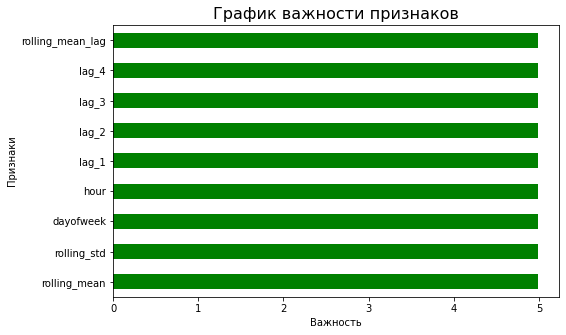

In [24]:
fi.plot(x='Feature', y='Importance', kind='barh', figsize=(8, 5), color = 'green', 
        title='График важности признаков', legend=None)
plt.title ('График важности признаков', fontsize=16)
plt.xlabel ('Важность')
plt.ylabel ('Признаки')


L2-регуляризация уравняла значимость признаков.

## Тестирование

In [25]:
preds = gsearch.best_estimator_.predict(X_test) 
print ('Метрика лучшей модели Ridge на тестовой выборке:', round(root_mean_squared_error(preds, y_test)))

Метрика лучшей модели Ridge на тестовой выборке: 43


Полученная метрика RMSE на тестовых данных соответствует заявленным требованиям (менее 48).

**ВЫВОДЫ:**

1. Для прогнозирования количества заказов такси по часам в исходные данные были добавлены новые признаки, наиболее важными среди которых являются количество заказов в предыдущем и предпредыдущем периодах (lag_1 и lag_2).

2. В ходе проведенного исследования были обучены и оценены 4 модели регрессии (модели линейной регресии с регуляризацией Lasso и Ridge, регрессия дерева решений и CatBoostRegressor), лучшие результаты среди которых показала модель линейной регресии с L2-регуляризацией при силе регуляризации = 0.1 (стандартная ошибка в размере 27 на тренировочных данных и 43 - на тестовых).